In [1]:
import os               # For file/directory handling
import joblib           # For saving and loading ML models efficiently
import re               # For regular expression operations (e.g., cleaning data)
import numpy as np      # For numerical operations
import pandas as pd     # For data manipulation and analysis
import matplotlib.pyplot as plt   # For basic plotting
import seaborn as sns             # For advanced and aesthetic data visualizations
from sklearn.model_selection import (
    train_test_split,    # Splits data into training and testing sets
    cross_val_score      # For performing cross-validation and evaluating model stability
)
from sklearn.ensemble import (
    RandomForestClassifier,        # Random Forest model
    GradientBoostingClassifier     # Gradient Boosting model
)
from sklearn.preprocessing import (
    StandardScaler,      # Scales numerical features to have zero mean and unit variance
    LabelEncoder,        # Encodes categorical labels as integers
    OneHotEncoder,       # Encodes categorical features as one-hot numeric arrays
    label_binarize       # Converts multiclass labels to binary for ROC computation
)
from sklearn.feature_extraction.text import CountVectorizer  # Converts text (e.g., DNA sequences) into a vector of token counts (e.g., k-mers)
from sklearn.metrics import (
    accuracy_score,              # Calculates overall accuracy
    classification_report,       # Generates precision, recall, F1-score per class
    confusion_matrix,            # Returns confusion matrix values
    ConfusionMatrixDisplay,      # Used to plot the confusion matrix
    precision_score,             # Calculates precision score
    recall_score,                # Calculates recall score
    f1_score,                    # Calculates F1-score
    roc_curve,                   # Plots ROC curve
    auc                          # Computes Area Under the Curve (AUC) for ROC
)

# hvr2

Generating K-mer features...

Gradient Boosting Model Performance:
Training Accuracy: 0.9417
Test Accuracy: 0.8500
Accuracy Gap: 0.0917

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       0.97      0.85      0.91        80
           2       0.87      0.97      0.92        80

    accuracy                           0.94       240
   macro avg       0.95      0.94      0.94       240
weighted avg       0.95      0.94      0.94       240


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.87      0.65      0.74        20
           2       0.72      0.90      0.80        20

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60


Confusion Matrix:
[[20  0  

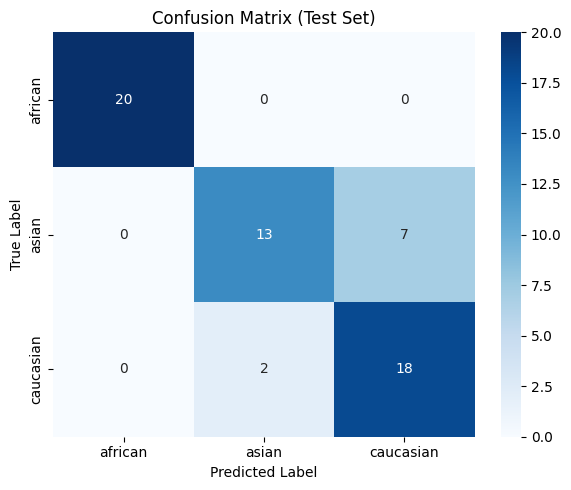


Training and evaluation complete!
Final model test accuracy: 0.8500


In [2]:
# Load Dataset
df = pd.read_csv('hvr2_cleaned_sequences.csv')

# Select Features and Target
X = df['HVR2']  # Only using HVR1 sequences
y = df['ethnicity']  # Ethnicity as the target variable

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode ethnicity labels (target)
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def generate_kmer_features(sequences, k=4):
    """ Convert sequences into k-mer frequency features using CountVectorizer. """
    # Check if sequences is a DataFrame or Series
    if isinstance(sequences, pd.DataFrame):
        # If it's a DataFrame, use the first column
        sequences_list = sequences.iloc[:, 0].tolist()
    else:
        # If it's a Series, convert directly to list
        sequences_list = sequences.tolist()

    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    kmer_features = vectorizer.fit_transform(sequences_list)
    return kmer_features, vectorizer

# K-mer Encoding (only on training data)
print("Generating K-mer features...")
X_train_kmer, kmer_vectorizer = generate_kmer_features(X_train)

# Feature Scaling for K-mer features (only on training data)
scaler_kmer = StandardScaler(with_mean=False)  # Preserve sparsity for sparse matrices
X_train_kmer_scaled = scaler_kmer.fit_transform(X_train_kmer)

# Convert sparse matrix to dense for model training
X_train_selected = X_train_kmer_scaled.toarray()

# Apply same transformations to test data
X_test_kmer = kmer_vectorizer.transform(X_test.astype(str))
X_test_kmer_scaled = scaler_kmer.transform(X_test_kmer)
X_test_selected = X_test_kmer_scaled.toarray()

# Train Gradient Boosting model with the original data
final_gb = GradientBoostingClassifier(random_state=42)
final_gb.fit(X_train_selected, y_train_encoded)

# Predict on training and test sets
y_train_pred = final_gb.predict(X_train_selected)
y_test_pred = final_gb.predict(X_test_selected)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
accuracy_gap = train_accuracy - test_accuracy

# Print results
print("\nGradient Boosting Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Accuracy Gap: {accuracy_gap:.4f}")

# Print classification reports
print("\nClassification Report (Training Set):")
print(classification_report(y_train_encoded, y_train_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test_encoded, y_test_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)
class_names = label_encoder.classes_

# Print confusion matrix
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()


print("\nTraining and evaluation complete!")
print(f"Final model test accuracy: {test_accuracy:.4f}")

# combined

In [4]:
# Load Dataset
df = pd.read_csv('hvr1_hvr2_cleaned_sequences.csv')

# Concatenate HVR1 and HVR2 into a single sequence
df['combined'] = df['HVR1'] + df['HVR2']  # Concatenate HVR1 and HVR2 sequences

# Select Features and Target
X = df['combined']  # Use concatenated HVR1 and HVR2 sequences
y = df['ethnicity']  # Ethnicity as the target variable

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode ethnicity labels (target)
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def generate_kmer_features(sequences, k=4):
    """ Convert sequences into k-mer frequency features using CountVectorizer. """
    # Check if sequences is a DataFrame or Series
    if isinstance(sequences, pd.DataFrame):
        # If it's a DataFrame, use the first column
        sequences_list = sequences.iloc[:, 0].tolist()
    else:
        # If it's a Series, convert directly to list
        sequences_list = sequences.tolist()

    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    kmer_features = vectorizer.fit_transform(sequences_list)
    return kmer_features, vectorizer

# K-mer Encoding (only on training data)
print("Generating K-mer features...")
X_train_kmer, kmer_vectorizer = generate_kmer_features(X_train)

# Feature Scaling for K-mer features (only on training data)
scaler_kmer = StandardScaler(with_mean=False)  # Preserve sparsity for sparse matrices
X_train_kmer_scaled = scaler_kmer.fit_transform(X_train_kmer)

# Convert sparse matrix to dense for model training
X_train_selected = X_train_kmer_scaled.toarray()

# Apply same transformations to test data
X_test_kmer = kmer_vectorizer.transform(X_test.astype(str))
X_test_kmer_scaled = scaler_kmer.transform(X_test_kmer)
X_test_selected = X_test_kmer_scaled.toarray()

# Train Gradient Boosting model with the combined data
final_gb = GradientBoostingClassifier(random_state=42)
final_gb.fit(X_train_selected, y_train_encoded)

# Predict on training and test sets
y_train_pred = final_gb.predict(X_train_selected)
y_test_pred = final_gb.predict(X_test_selected)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
accuracy_gap = train_accuracy - test_accuracy

# Print results
print("\nGradient Boosting Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Accuracy Gap: {accuracy_gap:.4f}")

# Print classification reports
print("\nClassification Report (Training Set):")
print(classification_report(y_train_encoded, y_train_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test_encoded, y_test_pred))

print("\nTraining and evaluation complete!")
print(f"Final model test accuracy: {test_accuracy:.4f}")


Generating K-mer features...

Gradient Boosting Model Performance:
Training Accuracy: 1.0000
Test Accuracy: 0.9500
Accuracy Gap: 0.0500

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.95      0.90      0.92        20
           2       0.90      0.95      0.93        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60


Training and evaluation com

<Figure size 1000x800 with 0 Axes>

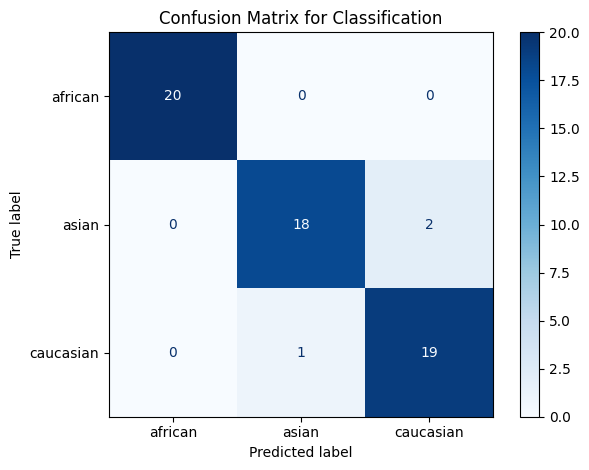


Training Accuracy: 1.0000
Testing Accuracy: 0.9500

Precision: 0.9507
Recall: 0.9500
F1 Score: 0.9500

Cross-Validation Scores:
[0.89583333 0.91666667 0.89583333 0.91666667 0.97916667]
Mean CV Score: 0.9208
Standard Deviation of CV Scores: 0.0306


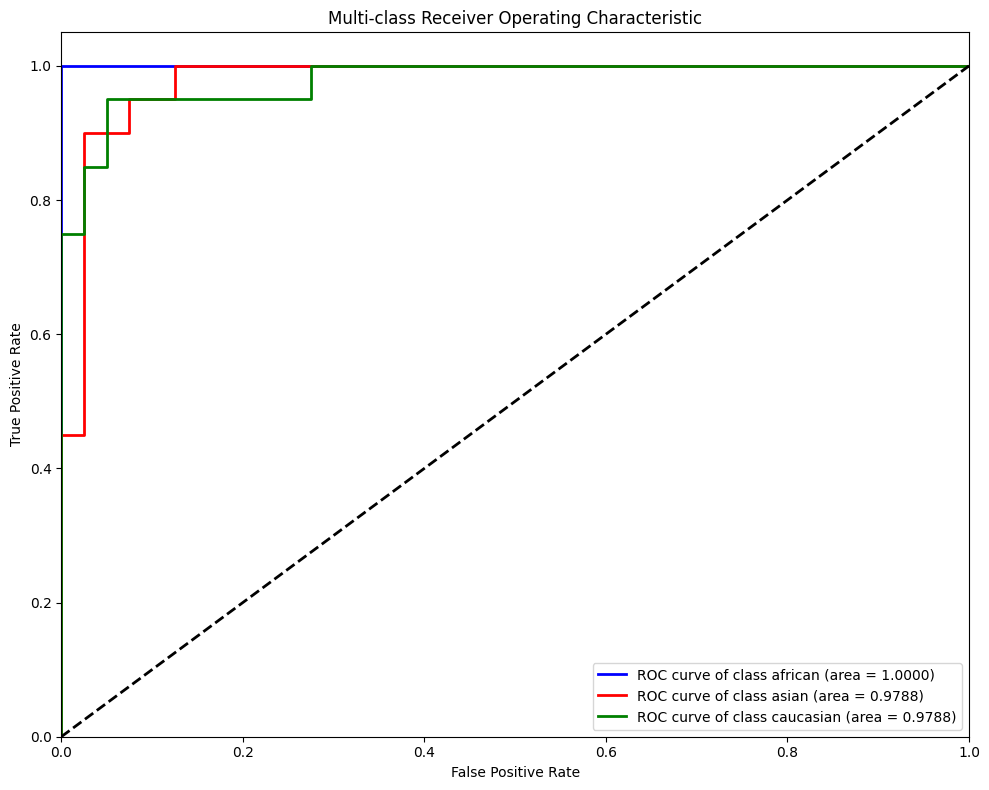


Micro-average AUC: 0.9907

Evaluation complete. Check the generated visualization files:
1. confusion_matrix.png
2. multiclass_roc_curve.png


In [5]:
# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test_encoded, y_test_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Classification')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# ---------- Accuracy, Precision, Recall, F1 Score ----------
train_accuracy = accuracy_score(y_train_encoded, final_gb.predict(X_train_selected))
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# For multiclass, we need to specify the averaging method
precision = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall = recall_score(y_test_encoded, y_test_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ---------- Cross-Validation Scores ----------
cv_scores = cross_val_score(final_gb, X_train_selected, y_train_encoded, cv=5)
print(f"\nCross-Validation Scores:")
print(cv_scores)
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")

# ---------- Multiclass ROC Curve ----------
n_classes = len(np.unique(y_test_encoded))
classes = np.unique(y_test_encoded)

# Get the predicted probabilities for each class
y_test_proba = final_gb.predict_proba(X_test_selected)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Binarize the labels for one-vs-rest approach
y_test_bin = label_binarize(y_test_encoded, classes=classes)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.4f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('multiclass_roc_curve.png')
plt.show()

# Calculate the micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")

# ---------- Summary ----------
print("\nEvaluation complete. Check the generated visualization files:")
print("1. confusion_matrix.png")
print("2. multiclass_roc_curve.png")

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Define the Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Define the range of CV values to test (3 to 10)
cv_values = range(3, 11)

# Dictionary to store the mean cross-validation accuracy for each CV value
cv_accuracies = {}

# Calculate cross-validation accuracy for each CV value
for cv in cv_values:
    cv_scores = cross_val_score(gb_clf, X_train_kmer_scaled, y_train_encoded, cv=cv, scoring='accuracy')
    cv_accuracies[cv] = cv_scores.mean()

# Print the cross-validation accuracies
print("Cross-Validation Accuracies for Gradient Boosting:")
for cv, accuracy in cv_accuracies.items():
    print(f"CV={cv}: Mean Accuracy = {accuracy:.4f}")

# Find the best CV value (the one with the highest mean accuracy)
best_cv = max(cv_accuracies, key=cv_accuracies.get)
best_accuracy = cv_accuracies[best_cv]

print(f"\nBest CV Value: {best_cv} with Mean Accuracy = {best_accuracy:.4f}")

Cross-Validation Accuracies for Gradient Boosting:
CV=3: Mean Accuracy = 0.8917
CV=4: Mean Accuracy = 0.9083
CV=5: Mean Accuracy = 0.9208
CV=6: Mean Accuracy = 0.9042
CV=7: Mean Accuracy = 0.9251
CV=8: Mean Accuracy = 0.9250
CV=9: Mean Accuracy = 0.9378
CV=10: Mean Accuracy = 0.9250

Best CV Value: 9 with Mean Accuracy = 0.9378


Confusion Matrix:
[[20  0  0]
 [ 0 18  2]
 [ 0  1 19]]


<Figure size 1000x800 with 0 Axes>

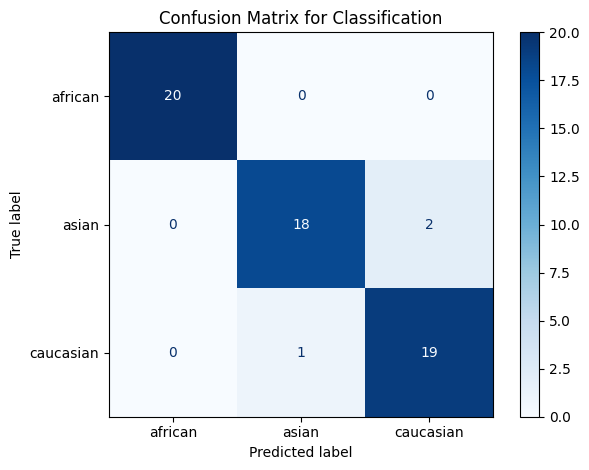


Training Accuracy: 1.0000
Testing Accuracy: 0.9500

Precision: 0.9507
Recall: 0.9500
F1 Score: 0.9500

Cross-Validation Scores:
[0.88888889 0.96296296 0.92592593 0.92592593 0.96296296 0.88888889
 0.92307692 1.         0.96153846]
Mean CV Score: 0.9378
Standard Deviation of CV Scores: 0.0349


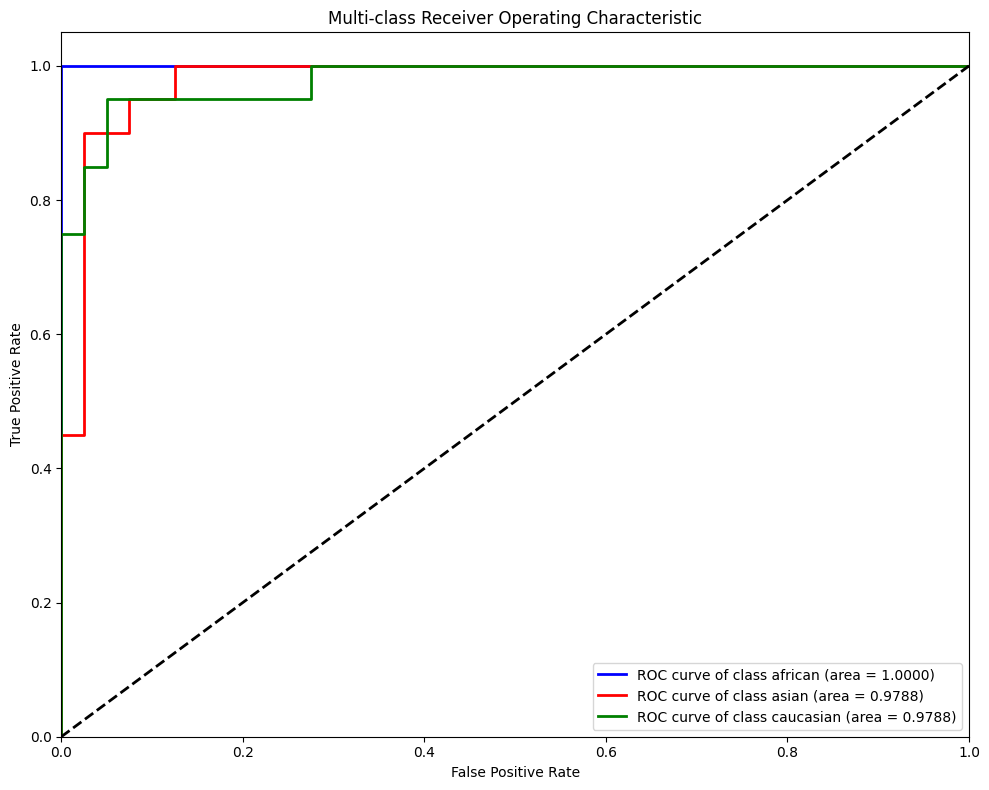


Micro-average AUC: 0.9907

Evaluation complete. Check the generated visualization files:
1. confusion_matrix.png
2. multiclass_roc_curve.png


In [7]:
# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test_encoded, y_test_pred)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Classification')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# ---------- Accuracy, Precision, Recall, F1 Score ----------
train_accuracy = accuracy_score(y_train_encoded, final_gb.predict(X_train_selected))
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# For multiclass, we need to specify the averaging method
precision = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall = recall_score(y_test_encoded, y_test_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ---------- Cross-Validation Scores ----------
cv_scores = cross_val_score(final_gb, X_train_selected, y_train_encoded, cv=9)
print(f"\nCross-Validation Scores:")
print(cv_scores)
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")

# ---------- Multiclass ROC Curve ----------
n_classes = len(np.unique(y_test_encoded))
classes = np.unique(y_test_encoded)

# Get the predicted probabilities for each class
y_test_proba = final_gb.predict_proba(X_test_selected)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Binarize the labels for one-vs-rest approach
y_test_bin = label_binarize(y_test_encoded, classes=classes)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.4f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('multiclass_roc_curve.png')
plt.show()

# Calculate the micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")

# ---------- Summary ----------
print("\nEvaluation complete. Check the generated visualization files:")
print("1. confusion_matrix.png")
print("2. multiclass_roc_curve.png")

In [ ]:
# Use cross-validation accuracy instead of training accuracy
cv_mean_accuracy = cv_scores.mean()  # Mean cross-validation accuracy

print(f"\nCross-Validation Accuracy (instead of Training Accuracy): {cv_mean_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")



Cross-Validation Accuracy (instead of Training Accuracy): 0.9378
Testing Accuracy: 0.9500


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the distribution for each hyperparameter
param_dist = {
    'n_estimators': randint(50, 500),  # Random integer between 50 and 500
    'learning_rate': uniform(0.01, 0.3),  # Uniform distribution between 0.01 and 0.3
    'max_depth': randint(3, 10),  # Random integer between 3 and 10
    'min_samples_split': randint(2, 20),  # Random integer between 2 and 20
    'min_samples_leaf': randint(1, 10),  # Random integer between 1 and 10
    'subsample': uniform(0.5, 0.5)  # Uniform distribution between 0.5 and 1.0
}

# Initialize RandomizedSearchCV with 3-fold cross-validation and 100 iterations
randomized_search = RandomizedSearchCV(final_gb, param_distributions=param_dist,
                                       n_iter=100, cv=9, scoring='accuracy', n_jobs=-1, verbose=2)

randomized_search.fit(X_train_selected, y_train_encoded)

best_params = randomized_search.best_params_
best_model = randomized_search.best_estimator_

print("\nBest Hyperparameters (Randomized Search):")
print(best_params)

y_test_pred_tuned = best_model.predict(X_test_selected)
tuned_test_accuracy = accuracy_score(y_test_encoded, y_test_pred_tuned)
print(f"\nTest Accuracy after tuning (Randomized Search): {tuned_test_accuracy:.4f}")


Fitting 9 folds for each of 100 candidates, totalling 900 fits


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1650, in _get_outputs
    yield from self._retrieve()
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1762, in _retrieve
    time.sleep(0.01)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-ef870b0eb809>", line 18, in <cell line: 0>
    randomized_search.fit(X_train_selected, y_train_encoded)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py", line 1024, in fit
    self._run_search

TypeError: object of type 'NoneType' has no len()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    # Tree structure parameters
    'n_estimators': [50, 100, 200, 300, 500],  # Number of boosting stages
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 25],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10, 20, 30],  # Minimum samples needed to split a node
    'min_samples_leaf': [1, 2, 3, 5, 10, 12, 14, 20],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', 0.7, 0.8, 0.9, None],  # Number of features to consider

    # Learning parameters
    'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1, 0.15],  # Shrinks contribution of each tree
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples to fit individual base learners

    # Split quality parameters
    'min_impurity_decrease': [0, 0.0001, 0.001, 0.01]  # Minimum improvement needed for split
}


# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(final_gb, param_grid, cv=9, scoring='accuracy', n_jobs=-1, verbose=2)

# Perform Grid Search
grid_search.fit(X_train_selected, y_train_encoded)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("\nBest Hyperparameters:")
print(best_params)

# Evaluate the tuned model on the test set
y_test_pred_tuned = best_model.predict(X_test_selected)

# Compute accuracy after tuning
tuned_test_accuracy = accuracy_score(y_test_encoded, y_test_pred_tuned)
print(f"\nTest Accuracy after tuning: {tuned_test_accuracy:.4f}")


NameError: name 'final_gb' is not defined

Training Accuracy: 100.00%
Testing Accuracy: 95.00%
Cross-Validation Accuracy (5-fold): 90.47%


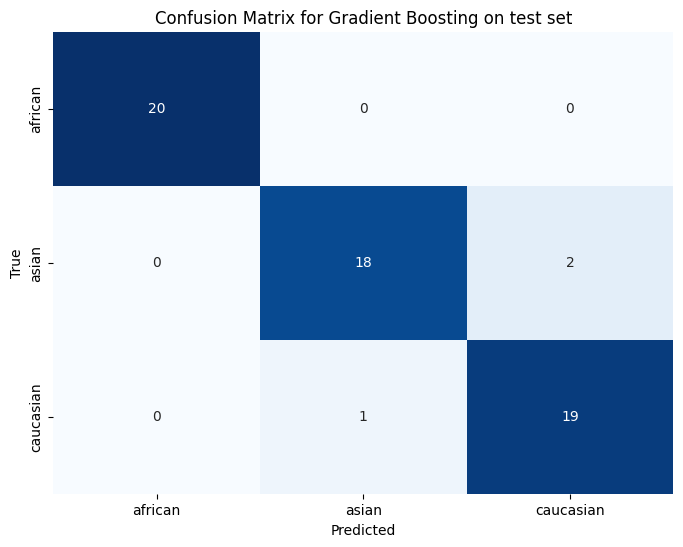


Classification Report (Test Set):
              precision    recall  f1-score   support

     african       1.00      1.00      1.00        20
       asian       0.95      0.90      0.92        20
   caucasian       0.90      0.95      0.93        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



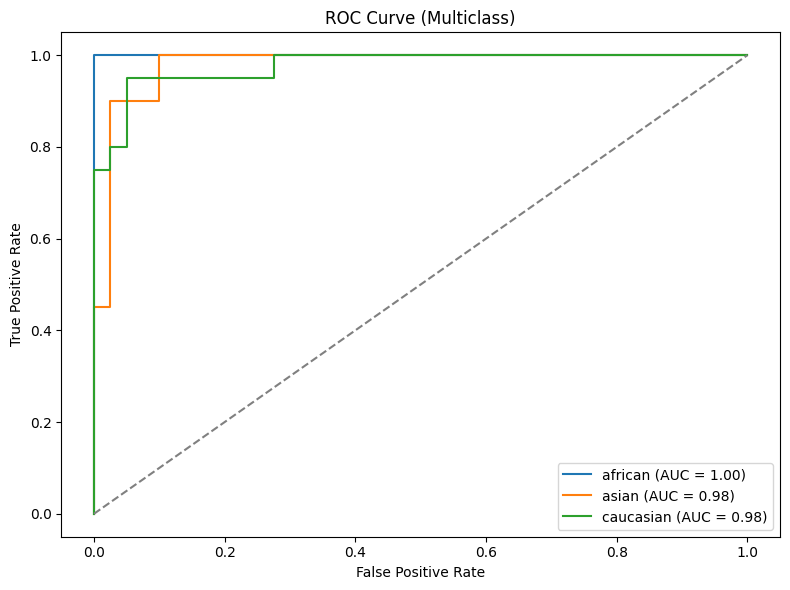

In [8]:
# Assuming you already have your data, model, and preprocessing set up.

ethnicity_labels = y_train.astype('category').cat.categories

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ROC Curve for multiclass
def plot_roc_curve_multiclass(y_true, y_score, class_labels, title="ROC Curve (Multiclass)"):
    from sklearn.preprocessing import label_binarize

    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves with actual class names
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


# Example usage after training your model
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=5,
    subsample=0.85,
    max_features=0.8,
    random_state=42
)

# Step 1: Fit the model
gb_clf.fit(X_train_kmer_scaled, y_train_encoded)  # Use the encoded labels for y_train

# Step 2: Get the predicted labels for the test set
y_train_pred = gb_clf.predict(X_train_kmer_scaled)  # Predicted labels for the training set
y_test_pred = gb_clf.predict(X_test_kmer_scaled)  # Predicted labels for the test set

# Step 3: Get the predicted probabilities for the ROC curve (for multiclass classification)
y_test_prob = gb_clf.predict_proba(X_test_kmer_scaled)  # Probabilities for each class

# Step 4: Calculate accuracy
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)  # Training accuracy
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)  # Testing accuracy

# Cross-validation accuracy
cv_accuracy = cross_val_score(gb_clf, X_train_kmer_scaled, y_train_encoded, cv=9, scoring='accuracy').mean()  # 5-fold CV

# Print accuracies
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
print(f"Cross-Validation Accuracy (5-fold): {cv_accuracy * 100:.2f}%")

# Step 5: Plot Confusion Matrix
plot_confusion_matrix(y_test_encoded, y_test_pred, ethnicity_labels, title="Confusion Matrix for Gradient Boosting on test set")

# Step 6: Classification Report (precision, recall, F1-score)
print("\nClassification Report (Test Set):")
print(classification_report(y_test_encoded, y_test_pred, target_names=ethnicity_labels))

# Step 7: Plot ROC Curve for Multiclass
num_classes = len(np.unique(y_test_encoded))  # Number of classes
plot_roc_curve_multiclass(y_test_encoded, y_test_prob, class_labels=ethnicity_labels)




# validation

# for integration

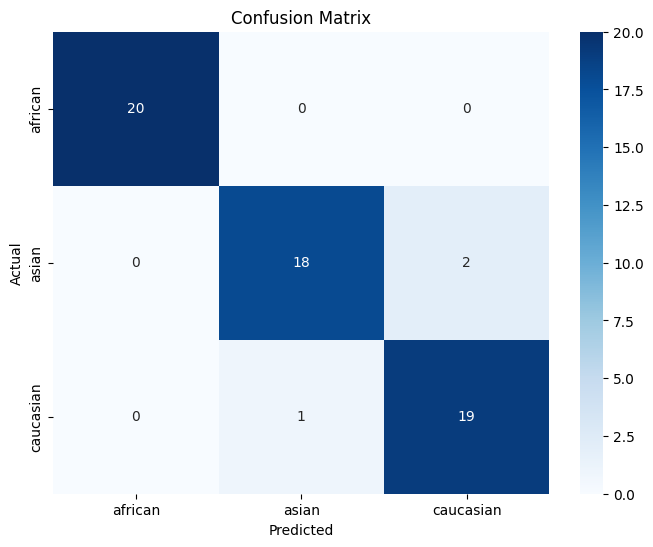


Classification Report:
               precision    recall  f1-score   support

     african       1.00      1.00      1.00        20
       asian       0.95      0.90      0.92        20
   caucasian       0.90      0.95      0.93        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60


Cross-Validation Accuracy: 0.9000 (+/- 0.0243)


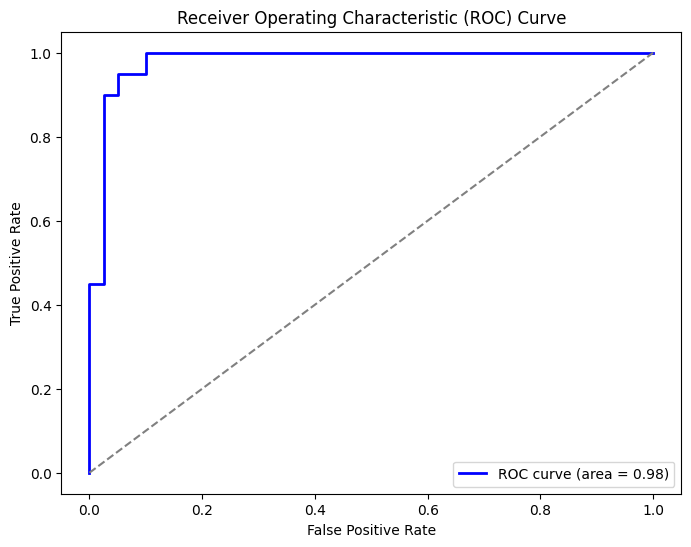

In [9]:
# Load Dataset
df = pd.read_csv('hvr1_hvr2_cleaned_sequences.csv')

df['combined'] = df['HVR1'] + df['HVR2']
X = df['combined']
y = df['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def generate_kmer_features(sequences, k=4):
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    return vectorizer.fit_transform(sequences.astype(str)), vectorizer

X_train_kmer, kmer_vectorizer = generate_kmer_features(X_train)
X_test_kmer = kmer_vectorizer.transform(X_test.astype(str))

scaler_kmer = StandardScaler(with_mean=False)
X_train_kmer_scaled = scaler_kmer.fit_transform(X_train_kmer)
X_test_kmer_scaled = scaler_kmer.transform(X_test_kmer)

X_train_selected = X_train_kmer_scaled.toarray()
X_test_selected = X_test_kmer_scaled.toarray()

gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=5,
    subsample=0.85,
    max_features=0.8,
    random_state=42
)

gb_clf.fit(X_train_selected, y_train_encoded)

os.makedirs('model_files', exist_ok=True)
joblib.dump(label_encoder, 'model_files/label_encoder.joblib')
joblib.dump(kmer_vectorizer, 'model_files/kmer_vectorizer.joblib')
joblib.dump(scaler_kmer, 'model_files/scaler_kmer.joblib')
joblib.dump(gb_clf, 'model_files/gradient_boosting_classifier.joblib')
np.savetxt('model_files/class_names.txt', label_encoder.classes_, fmt='%s')

def evaluate_model():
    y_pred = gb_clf.predict(X_test_selected)
    y_pred_proba = gb_clf.predict_proba(X_test_selected)[:, 1]  # Probabilities for ROC curve

    # Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

    # Cross-Validation Accuracy
    cv_scores = cross_val_score(gb_clf, X_train_selected, y_train_encoded, cv=5, scoring='accuracy')
    print("\nCross-Validation Accuracy: %.4f (+/- %.4f)" % (cv_scores.mean(), cv_scores.std()))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba, pos_label=1)  # Adjust pos_label if needed
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

evaluate_model()


Validation Accuracy: 0.7879
Testing Accuracy: 0.7879
Confusion Matrix:
[[22  0  0]
 [ 1 14  7]
 [ 0  6 16]]


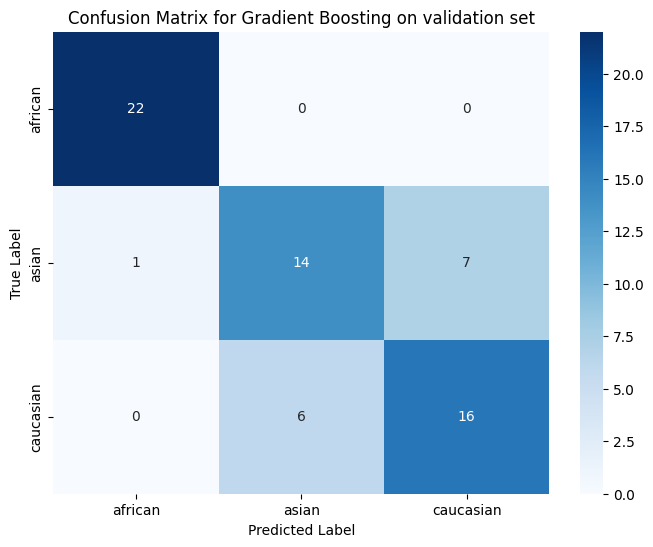

Classification Report (Validtaion set):
              precision    recall  f1-score   support

     african       0.96      1.00      0.98        22
       asian       0.70      0.64      0.67        22
   caucasian       0.70      0.73      0.71        22

    accuracy                           0.79        66
   macro avg       0.78      0.79      0.79        66
weighted avg       0.78      0.79      0.79        66



In [11]:
# Load Dataset
df = pd.read_csv('hvr1_hvr2_cleaned_sequences_validation.csv')

# Concatenate HVR1 and HVR2 into a single sequence
df['combined'] = df['HVR1'] + df['HVR2']

# Prepare data
X = df['combined']
y = df['ethnicity']

# Load pretrained components
label_encoder = joblib.load('model_files/label_encoder.joblib')
kmer_vectorizer = joblib.load('model_files/kmer_vectorizer.joblib')
scaler_kmer = joblib.load('model_files/scaler_kmer.joblib')
gb_clf = joblib.load('model_files/gradient_boosting_classifier.joblib')

# Transform test data
X_test = kmer_vectorizer.transform(X.astype(str))
X_test = scaler_kmer.transform(X_test)
y_test = label_encoder.transform(y)
y_pred = gb_clf.predict(X_test.toarray())

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Validation Accuracy: {accuracy:.4f}")

# Calculate and display testing accuracy
test_accuracy = np.mean(y_pred == y_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Gradient Boosting on validation set')
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report (Validtaion set):")
print(class_report)


In [12]:
class EthnicityPredictor:
    def __init__(self,
                 label_encoder_path='model_files/label_encoder.joblib',
                 vectorizer_path='model_files/kmer_vectorizer.joblib',
                 scaler_path='model_files/scaler_kmer.joblib',
                 classifier_path='model_files/gradient_boosting_classifier.joblib'):
        """
        Initialize the predictor by loading saved model components

        Parameters:
        -----------
        label_encoder_path : str
            Path to saved label encoder
        vectorizer_path : str
            Path to saved k-mer vectorizer
        scaler_path : str
            Path to saved feature scaler
        classifier_path : str
            Path to saved gradient boosting classifier
        """
        # Load saved model components
        self.label_encoder = joblib.load(label_encoder_path)
        self.vectorizer = joblib.load(vectorizer_path)
        self.scaler = joblib.load(scaler_path)
        self.classifier = joblib.load(classifier_path)

        # Load class names for reference
        try:
            self.class_names = np.loadtxt('model_files/class_names.txt', dtype=str)
        except:
            self.class_names = self.label_encoder.classes_

    def predict(self, sequences):
        """
        Predict ethnicity for given sequences

        Parameters:
        -----------
        sequences : list or str
            Input sequence(s) to predict

        Returns:
        --------
        list
            Predicted ethnicity labels
        """
        # Ensure sequences is a list
        if isinstance(sequences, str):
            sequences = [sequences]

        # Convert sequences to strings
        sequences = [str(seq) for seq in sequences]

        # Vectorize sequences
        X_kmer = self.vectorizer.transform(sequences)

        # Scale features
        X_scaled = self.scaler.transform(X_kmer)

        # Predict
        y_pred_encoded = self.classifier.predict(X_scaled.toarray())

        # Decode predictions
        return [self.class_names[pred] for pred in y_pred_encoded]

    def predict_proba(self, sequences):
        """
        Predict ethnicity probabilities for given sequences

        Parameters:
        -----------
        sequences : list or str
            Input sequence(s) to predict

        Returns:
        --------
        list of dicts
            Probability predictions for each class
        """
        # Ensure sequences is a list
        if isinstance(sequences, str):
            sequences = [sequences]

        # Convert sequences to strings
        sequences = [str(seq) for seq in sequences]

        # Vectorize sequences
        X_kmer = self.vectorizer.transform(sequences)

        # Scale features
        X_scaled = self.scaler.transform(X_kmer)

        # Predict probabilities
        y_pred_proba = self.classifier.predict_proba(X_scaled.toarray())

        # Convert to list of dicts with class names as keys
        return [
            dict(zip(self.class_names, proba))
            for proba in y_pred_proba
        ]

def predict_ethnicity(hvr1_sequence, hvr2_sequence):
    """
    Predict ethnicity based on HVR1 and HVR2 sequences

    Parameters:
    -----------
    hvr1_sequence : str
        HVR1 DNA sequence
    hvr2_sequence : str
        HVR2 DNA sequence

    Returns:
    --------
    str
        Predicted ethnicity
    """
    # Combine HVR1 and HVR2 sequences
    combined_sequence = hvr1_sequence + hvr2_sequence

    # Initialize predictor
    predictor = EthnicityPredictor()

    # Predict ethnicity
    predictions = predictor.predict(combined_sequence)

    # Return the first (and likely only) prediction
    return predictions[0]

# Example usage
def main():
    # Get input from user
    hvr1_input = input("Enter HVR1 sequence: ")
    hvr2_input = input("Enter HVR2 sequence: ")

    try:
        # Predict ethnicity
        ethnicity = predict_ethnicity(hvr1_input, hvr2_input)
        print(f"Predicted Ethnicity: {ethnicity}")

        # Optional: Get probabilities
        predictor = EthnicityPredictor()
        combined_sequence = hvr1_input + hvr2_input
        probabilities = predictor.predict_proba(combined_sequence)
        print("\nDetailed Probabilities:")
        for ethnicity, probability in probabilities[0].items():
            print(f"{ethnicity}: {probability:.2%}")

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

Enter HVR1 sequence: NNNNNCTTTCATGGGGAAACAGATTTGGGTACCACCCAAGTATTGACTCACCCATCAACAACCGCTATGTATTTCGTACATTACTGCCAGCCACCATGAATATTGTACGGTACCATAAATACTTGACCACCTGTAGTACATAAAAACCCAATCCACATCAAANACCCCCCCCCCATGCTTACNNAAGCAAGTACAGCAATCAACCTTCAACTATCACACATCAACTGCAANNNNNNNNCTCCAAAGCCACCCCTCACCCANCTAGGATACCAACAAACCTATCCACCCTTAACAGTACATAGTACATAAANNNNNNNNNNNNACCATTTACCGTACATAGCACATTACAGTCAAATCCCCTCTCGCCCCCNNNNNNNNNNNNN
Enter HVR2 sequence: NNNNNNNTGCACGCGATAGCANNNTTGCGAGACGCTGGAGNNCCGGAGCACCCTATNNNNGTCGCAGTATCTGTCTTTGATTCCTGCCTCATCCCATNNNTATTNNNNNNTATCGCACCTACGTNNNNNTCAATATTACAGGCGAACNNNNNNNNNNNNNNNNNNNNNNNNNNNATACTTACTAAAGTGTGTTAATTAATTAATGCTTGNNTAGGACATAGTAATAACAATTGAATGTCTGCACAGCCGCTTTCCACACAGACATCATAACAAAAAATTTNNCCACCNNNNNNNNNNNNNNNNNNNNAAANCCCCCCCCTCCCCCCGCTTCTGGCCACAGCACNNNNNNNTTAAACNNNNNNNNNNNNNNNNNNNNNNNNNNN
Predicted Ethnicity: asian

Detailed Probabilities:
african: 12.29%
asian: 67.99%
caucasian: 19.72%
